In [1]:
# Data
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
import impl.layer as l

# Dataset preparation and pre-processing
mnist = input_data.read_data_sets('data/MNIST_data/', one_hot=False)

X_train, y_train = mnist.train.images, mnist.train.labels
X_val, y_val = mnist.validation.images, mnist.validation.labels
X_test, y_test = mnist.test.images, mnist.test.labels

Extracting data/MNIST_data/train-images-idx3-ubyte.gz
Extracting data/MNIST_data/train-labels-idx1-ubyte.gz
Extracting data/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting data/MNIST_data/t10k-labels-idx1-ubyte.gz


In [2]:
# Pre-processing: normalizing
def normalize(X):
    # max scale for images 255= 2**8= 8 bit grayscale for each channel
    return (X - X.mean(axis=0)) #/ X.std(axis=0)

X_train, X_val, X_test = normalize(X=X_train), normalize(X=X_val), normalize(X=X_test)

In [3]:
# Model
import impl.layer as l # or from impl.layer import *
from impl.loss import * # import all functions from impl.loss file # import impl.loss as loss_func
from sklearn.utils import shuffle as skshuffle

class FFNN:

    def __init__(self, D, C, H, L):
        self.L = L # layers
        self.C = C # classes
        self.losses = {'train':[], 'train_acc':[], 
                       'valid':[], 'valid_acc':[], 
                       'test':[], 'test_acc':[]}
        
        self.model = []
        self.grads = []
        low, high = -1, 1
        
        # Input layer: weights/ biases
        m = dict(W_pos=np.random.uniform(size=(D, H), low=low, high=high) / np.sqrt(D / 2.), 
                 W_neg=np.random.uniform(size=(D, H), low=low, high=high) / np.sqrt(D / 2.),
                 b_pos=np.zeros((1, H)),
                 b_neg=np.zeros((1, H)))
        self.model.append(m) # model[0]
        # Input layer: gradients
        self.grads.append({key: np.zeros_like(val) for key, val in self.model[0].items()})

        # Hidden layers: weights/ biases
        m_L = []
        for _ in range(L):
            m = dict(W_pos=np.random.uniform(size=(H, H), low=low, high=high) / np.sqrt(H / 2.), 
                     W_neg=np.random.uniform(size=(H, H), low=low, high=high) / np.sqrt(H / 2.),
                     b_pos=np.zeros((1, H)),
                     b_neg=np.zeros((1, H)))
            m_L.append(m)
        self.model.append(m_L) # model[1]
        # Hidden layer: gradients
        grad_L = []
        for _ in range(L):
            grad_L.append({key: np.zeros_like(val) for key, val in self.model[1][0].items()})
        self.grads.append(grad_L)
        
        # Output layer: weights/ biases
        m = dict(W_pos=np.random.uniform(size=(H, C), low=low, high=high) / np.sqrt(H / 2.),
                 W_neg=np.random.uniform(size=(H, C), low=low, high=high) / np.sqrt(H / 2.),
                 b_pos=np.zeros((1, C)),
                 b_neg=np.zeros((1, C)))
        self.model.append(m) # model[2]
        # Output layer: gradients
        self.grads.append({key: np.zeros_like(val) for key, val in self.model[2].items()})
        
    def fc_forward(self, X, W, b):
        out = (X @ W) + b
        cache = (W, X)
        return out, cache

    def fc_backward(self, dout, cache):
        W, X = cache

        dW = X.T @ dout
        db = np.sum(dout, axis=0).reshape(1, -1) # db_1xn        
        dX = dout @ W.T # vanilla Backprop

        return dX, dW, db

    def train_forward(self, X, train):
        caches = []
        
        # Input layer
        y_pos, fc_cache_pos = self.fc_forward(X=(X>0), W=self.model[0]['W_pos'], 
                                              b=self.model[0]['b_pos'])
        y_neg, fc_cache_neg = self.fc_forward(X=(X<0), W=self.model[0]['W_neg'], 
                                              b=self.model[0]['b_neg'])
        y = y_pos + y_neg
        if train:
            caches.append((fc_cache_pos, fc_cache_neg)) # caches[0]
        X = y.copy() # pass to the next layer
        
        # Hidden layers
        fc_caches = []
        for layer in range(self.L):
            y_pos, fc_cache_pos = self.fc_forward(X=(X>0), W=self.model[1][layer]['W_pos'], 
                                                  b=self.model[1][layer]['b_pos'])
            y_neg, fc_cache_neg = self.fc_forward(X=(X<0), W=self.model[1][layer]['W_neg'], 
                                                  b=self.model[1][layer]['b_neg'])
            y = y_pos + y_neg
            if train:
                fc_caches.append((fc_cache_pos, fc_cache_neg))
            X = y.copy() # pass to next layer
        if train:
            caches.append(fc_caches) # caches[1]            
        
        # Output layer
        y_pos, fc_cache_pos = self.fc_forward(X=(X>0), W=self.model[2]['W_pos'], 
                                              b=self.model[2]['b_pos'])
        y_neg, fc_cache_neg = self.fc_forward(X=(X<0), W=self.model[2]['W_neg'], 
                                              b=self.model[2]['b_neg'])
        y = y_pos + y_neg
        y_prob = l.softmax(X=y)
        if train:
            caches.append((fc_cache_pos, fc_cache_neg)) # caches[2]

        return y_prob, caches

    def cross_entropy(self, y_prob, y_train):
        m = y_prob.shape[0]

        #         prob = l.softmax(y_pred)
        log_like = -np.log(y_prob[range(m), y_train]) # to avoid the devision by zero
        data_loss = np.sum(log_like) / m

        return data_loss

    def dcross_entropy(self, y_prob, y_train): # this is equal for both since the reg_loss (noise) derivative is ZERO.
        m = y_prob.shape[0]

        #         grad_y = l.softmax(y_pred)
        grad_y = y_prob
        grad_y[range(m), y_train] -= 1.
        grad_y /= m

        return grad_y

    def loss_function(self, y_prob, y_train):
        
        loss = self.cross_entropy(y_prob, y_train) # softmax is included
        dy = self.dcross_entropy(y_prob, y_train) # dsoftmax is included

        return loss, dy
        
    def train_backward(self, dy, caches):
        grads = self.grads.copy() # initialized by Zero in every iteration/epoch
        
        # Output layer
        fc_cache_pos, fc_cache_neg = caches[2]
        # softmax_backward is included in dcross_entropy.
        dX_pos, dW_pos, db_pos = self.fc_backward(dout=dy, cache=fc_cache_pos)
        dX_neg, dW_neg, db_neg = self.fc_backward(dout=dy, cache=fc_cache_neg)
        dX = dX_pos + dX_neg
        dy = dX.copy()
        grads[2]['W_pos'] = dW_pos
        grads[2]['b_pos'] = db_pos
        grads[2]['W_neg'] = dW_neg
        grads[2]['b_neg'] = db_neg

        # Hidden layer
        fc_caches = caches[1]
        for layer in reversed(range(self.L)):
            fc_cache_pos, fc_cache_neg = fc_caches[layer]
            dX_pos, dW_pos, db_pos = self.fc_backward(dout=dy, cache=fc_cache_pos)
            dX_neg, dW_neg, db_neg = self.fc_backward(dout=dy, cache=fc_cache_neg)
            dX = dX_pos + dX_neg
            dy = dX.copy()
            grads[1][layer]['W_pos'] = dW_pos
            grads[1][layer]['b_pos'] = db_pos
            grads[1][layer]['W_neg'] = dW_neg
            grads[1][layer]['b_neg'] = db_neg
            
        # Input layer
        fc_cache_pos, fc_cache_neg = caches[0]
        dX_pos, dW_pos, db_pos = self.fc_backward(dout=dy, cache=fc_cache_pos)
        dX_neg, dW_neg, db_neg = self.fc_backward(dout=dy, cache=fc_cache_neg)
        dX = dX_pos + dX_neg
        dy = dX.copy()
        grads[0]['W_pos'] = dW_pos
        grads[0]['b_pos'] = db_pos
        grads[0]['W_neg'] = dW_neg
        grads[0]['b_neg'] = db_neg

        return grads
    
    def test(self, X):
        y_prob, _ = self.train_forward(X, train=False)
        
        # if self.mode == 'classification':
        y_pred = np.argmax(y_prob, axis=1) # for loss ==err
        
        return y_pred, y_prob
        
    def get_minibatch(self, X, y, minibatch_size, shuffle):
        minibatches = []

        if shuffle:
            X, y = skshuffle(X, y)

        for i in range(0, X.shape[0], minibatch_size):
            X_mini = X[i:i + minibatch_size]
            y_mini = y[i:i + minibatch_size]
            minibatches.append((X_mini, y_mini))

        return minibatches

    def sgd(self, train_set, val_set, alpha, mb_size, n_iter, print_after):
        X_train, y_train = train_set
        X_val, y_val = val_set

        # Epochs
        for iter in range(1, n_iter + 1):

            # Minibatches
            minibatches = self.get_minibatch(X_train, y_train, mb_size, shuffle=True)
            idx = np.random.randint(0, len(minibatches))
            X_mini, y_mini = minibatches[idx]
            
            # Train the model
            y_prob, caches = self.train_forward(X_mini, train=True)
            _, dy = self.loss_function(y_prob, y_mini)
            grads = self.train_backward(dy, caches)
            
            # Update the model for input layer
            for key in grads[0].keys():
                self.model[0][key] -= alpha * grads[0][key]

            # Update the model for the hidden layers
            for layer in range(self.L):
                for key in grads[1][layer].keys():
                    self.model[1][layer][key] -= alpha * grads[1][layer][key]

            # Update the model for output layer
            for key in grads[2].keys():
                self.model[2][key] -= alpha * grads[2][key]
            
            # Training accuracy
            y_pred, y_prob = self.test(X_mini)
            loss, _ = self.loss_function(y_prob, y_mini) # softmax is included in entropy loss function
            self.losses['train'].append(loss)
            acc = np.mean(y_pred == y_mini) # confusion matrix
            self.losses['train_acc'].append(acc)

            # Validate the updated model
            y_pred, y_prob = self.test(X_val)
            valid_loss, _ = self.loss_function(y_prob, y_val) # softmax is included in entropy loss function
            self.losses['valid'].append(valid_loss)
            valid_acc = np.mean(y_pred == y_val) # confusion matrix
            self.losses['valid_acc'].append(valid_acc)
            
            # Test the final model
            y_pred, y_prob = nn.test(X_test)
            test_loss, _ = self.loss_function(y_prob, y_test) # softmax is included in entropy loss function
            self.losses['test'].append(test_loss)
            test_acc = np.mean(y_pred == y_test)
            self.losses['test_acc'].append(test_acc)
            # print('Test accuracy mean: {:.4f}, std: {:.4f}, loss: {:.4f}'.
            # format(acc.mean(), acc.std(), loss))
            
            # Print the model info: loss & accuracy or err & acc
            if iter % print_after == 0:
                print('Iter-{}, train loss-{:.4f}, acc-{:.4f}, valid loss-{:.4f}, acc-{:.4f}, test loss-{:.4f}, acc-{:.4f}'.format(
                   iter, loss, acc, valid_loss, valid_acc, test_loss, test_acc))

In [4]:
# Hyper-parameters
n_iter = 10000 # number of epochs
alpha = 1e-3 # learning_rate
mb_size = 50 # 2**10==1024 # width, timestep for sequential data or minibatch size
print_after = 100 # n_iter//10 # print loss for train, valid, and test
num_hidden_units = 32 # number of kernels/ filters in each layer
num_input_units = X_train.shape[1] # noise added at the input lavel as input noise we can use dX or for more improvement
num_output_units = y_train.max() + 1 # number of classes in this classification problem
num_layers = 2 # depth 

# Build the model/NN and learn it: running session.
nn = FFNN(C=num_output_units, D=num_input_units, H=num_hidden_units, L=num_layers)

nn.sgd(train_set=(X_train, y_train), val_set=(X_val, y_val), mb_size=mb_size, alpha=alpha, 
           n_iter=n_iter, print_after=print_after)

Iter-100, train loss-2.4998, acc-0.1400, valid loss-2.5139, acc-0.1086, test loss-2.5169, acc-0.1106
Iter-200, train loss-2.5590, acc-0.0800, valid loss-2.5117, acc-0.1072, test loss-2.4993, acc-0.1031
Iter-300, train loss-2.5085, acc-0.1000, valid loss-2.4311, acc-0.0978, test loss-2.4218, acc-0.1018
Iter-400, train loss-2.4153, acc-0.0800, valid loss-2.4075, acc-0.0928, test loss-2.4167, acc-0.0828
Iter-500, train loss-2.3044, acc-0.1800, valid loss-2.3377, acc-0.1132, test loss-2.3347, acc-0.1126
Iter-600, train loss-2.2622, acc-0.1000, valid loss-2.3436, acc-0.0820, test loss-2.3329, acc-0.0890
Iter-700, train loss-2.2992, acc-0.1000, valid loss-2.3045, acc-0.0812, test loss-2.2976, acc-0.0872
Iter-800, train loss-2.3098, acc-0.0200, valid loss-2.3016, acc-0.0248, test loss-2.3023, acc-0.0242
Iter-900, train loss-2.3289, acc-0.0400, valid loss-2.2993, acc-0.0290, test loss-2.3051, acc-0.0278
Iter-1000, train loss-2.2862, acc-0.0400, valid loss-2.2902, acc-0.0342, test loss-2.2969, 

Iter-8200, train loss-1.6501, acc-0.5800, valid loss-1.6947, acc-0.4828, test loss-1.6949, acc-0.4828
Iter-8300, train loss-1.7999, acc-0.4400, valid loss-1.6859, acc-0.4830, test loss-1.6874, acc-0.4852
Iter-8400, train loss-1.6111, acc-0.5800, valid loss-1.6810, acc-0.4860, test loss-1.6798, acc-0.4839
Iter-8500, train loss-1.7677, acc-0.4200, valid loss-1.6771, acc-0.4834, test loss-1.6771, acc-0.4830
Iter-8600, train loss-1.6909, acc-0.4400, valid loss-1.6732, acc-0.4902, test loss-1.6767, acc-0.4890
Iter-8700, train loss-1.7305, acc-0.4600, valid loss-1.6660, acc-0.4842, test loss-1.6663, acc-0.4863
Iter-8800, train loss-1.5591, acc-0.5600, valid loss-1.6693, acc-0.4730, test loss-1.6690, acc-0.4695
Iter-8900, train loss-1.6739, acc-0.5000, valid loss-1.6537, acc-0.4790, test loss-1.6554, acc-0.4744
Iter-9000, train loss-1.5202, acc-0.5800, valid loss-1.6376, acc-0.4890, test loss-1.6398, acc-0.4920
Iter-9100, train loss-1.6669, acc-0.4000, valid loss-1.6220, acc-0.4878, test loss

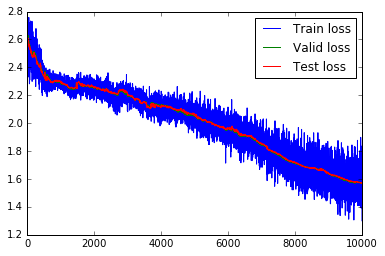

In [5]:
# # Display the learning curve and losses for training, validation, and testing
# %matplotlib inline
# %config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

plt.plot(nn.losses['train'], label='Train loss')
plt.plot(nn.losses['valid'], label='Valid loss')
plt.plot(nn.losses['test'], label='Test loss')
plt.legend()
plt.show()

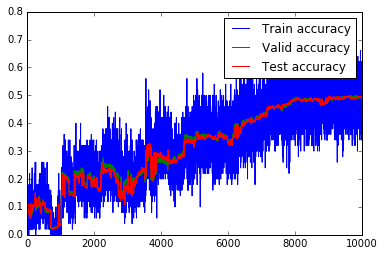

In [6]:
plt.plot(nn.losses['train_acc'], label='Train accuracy')
plt.plot(nn.losses['valid_acc'], label='Valid accuracy')
plt.plot(nn.losses['test_acc'], label='Test accuracy')
plt.legend()
plt.show()